In [17]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.ascii
%matplotlib inline

## Read in transit data for HD 17156 b

In [18]:
tr_data = astropy.io.ascii.read("UID_0013192_PLC_017.tbl.txt")

## Input the best-fit model

In [19]:
import pylightcurve as plc

# best-fit parameters from ExoFast
planet, stellar_logg, stellar_temperature, stellar_metallicity, rp_over_rs, \
fp_over_fs, period, sma_over_rs, eccentricity, inclination, periastron, mid_time = \
"HD 17156 b", 4.192, 6040.0, 0.19, 0.074451, 2.4367028655531474e-07, \
21.218473, 23.428833, 0.68, 87.07, 121.36, 2454438.483466

time_array = tr_data["BJD"].data

# Calculate Limb-darkening parameters
limb_darkening_coefficients = plc.clablimb('claret', stellar_logg, stellar_temperature, 
                                               stellar_metallicity, 'V')

# Calculate transiting light curve
flux_array = plc.transit('claret', limb_darkening_coefficients, rp_over_rs, period, sma_over_rs, 
                                        eccentricity, inclination, periastron, mid_time, time_array)

## Plot the best-fit model

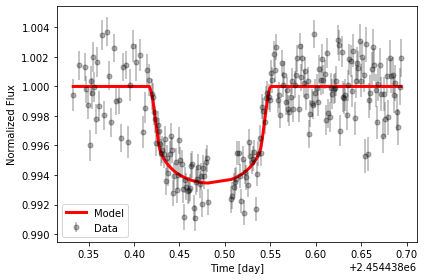

In [20]:
plt.errorbar(tr_data["BJD"], tr_data["Normalized_Flux"], tr_data["Normalized_Flux_Uncertainty"], ms=5, \
             marker="o", ls="none", label="Data", color="black", alpha=0.3)


plt.plot(time_array, flux_array, 'r-', lw=3, label="Model")
plt.ylim(plt.ylim()[0], plt.ylim()[1])
plt.xlabel('Time [day]')
plt.ylabel('Normalized Flux')
plt.legend()
plt.tight_layout()

## Now let's get to the fundamentals of modeling a transit light curve, the parameters are:
1. Limb darkening coefficients. They determines the shape of ingress and egress.
2. $\frac{R_p}{R_s}$, the radius ratio between the planet and the star. This parameters determines the transit depth $\delta$
3. Period
4. $\frac{a}{R_s}$, where $a$ is semi-major axis
5. Eccentricity
6. Inclination
7. Longitude of periastron
8. Transit middle time

![tr_02](tr_02.png)

## T, duration of transit is mainly determined by Period, $\frac{a}{R_s}$, and inclination ($i$), which is related to impact parameter $b$ ($b = \frac{a\cos i}{R_s}$):
![tr_03](tr_03.png)

## Let's first look at the limb darkening parameters. They can be found in Claret et al. 2012. Quadratic limb darkening is widely used, so we will use the quadratic parametrization to illustrate the limb darkening effect:
![tr_01](tr_01.png)

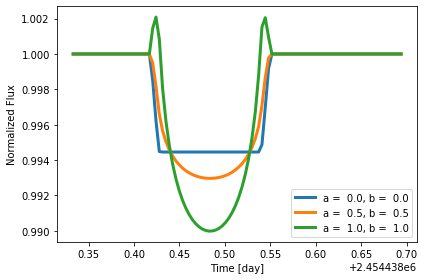

In [21]:
a_arr = np.array([0, 0.5, 1.0])
b_arr = np.array([0, 0.5, 1.0])

t_array = np.linspace(np.min(time_array), np.max(time_array), 100)

for i in np.arange(len(a_arr)):
    lm_coefs = [a_arr[i], b_arr[i]]
    # Calculate transiting light curve
    flux_array = plc.transit('quad', lm_coefs, rp_over_rs, period, sma_over_rs, 
                                            eccentricity, inclination, periastron, mid_time, t_array)
    plt.plot(t_array, flux_array, lw=3, label="a = {0:4.1f}, b = {1:4.1f}".format(lm_coefs[0], lm_coefs[1]))
plt.ylim(plt.ylim()[0], plt.ylim()[1])
plt.xlabel('Time [day]')
plt.ylabel('Normalized Flux')
plt.legend()
plt.tight_layout()

## As a and b increases, star limb becomes increasingly darker, the resulting light curve becomes more "V" shape. 

## $\frac{R_p}{R_s}$ determines the transit depth, $\delta = (\frac{R_p}{R_s})^2$

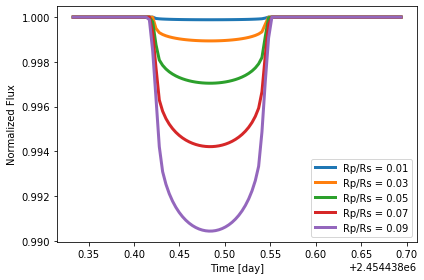

In [22]:
rp_rs_arr = np.arange(0.01, 0.1, 0.02)

for i in np.arange(len(rp_rs_arr)):
    rp_rs = rp_rs_arr[i]
    # Calculate transiting light curve
    flux_array = plc.transit('claret', limb_darkening_coefficients, rp_rs, period, sma_over_rs, 
                                            eccentricity, inclination, periastron, mid_time, t_array)
    plt.plot(t_array, flux_array, lw=3, label="Rp/Rs = {0:4.2f}".format(rp_rs))
plt.ylim(plt.ylim()[0], plt.ylim()[1])
plt.xlabel('Time [day]')
plt.ylabel('Normalized Flux')
plt.legend()
plt.tight_layout()

## Period detemines the transit duration, linearly as shown in equation 19

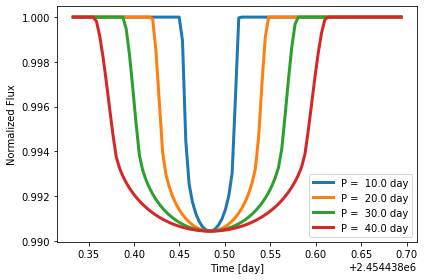

In [23]:
per_arr = np.arange(10, 50, 10)

for i in np.arange(len(per_arr)):
    per = per_arr[i]
    # Calculate transiting light curve
    flux_array = plc.transit('claret', limb_darkening_coefficients, rp_rs, per, sma_over_rs, 
                                            eccentricity, inclination, periastron, mid_time, t_array)
    plt.plot(t_array, flux_array, lw=3, label="P = {0:5.1f} day".format(per))
plt.ylim(plt.ylim()[0], plt.ylim()[1])
plt.xlabel('Time [day]')
plt.ylabel('Normalized Flux')
plt.legend()
plt.tight_layout()

## $\frac{a}{R_s}$ inverse-linearly determines the trasnit duration (equation 19). However, you may notice that period and $\frac{a}{R_s}$ are not independent variables. Period and $a$ are related to each other by the Kepler's 3rd law. 

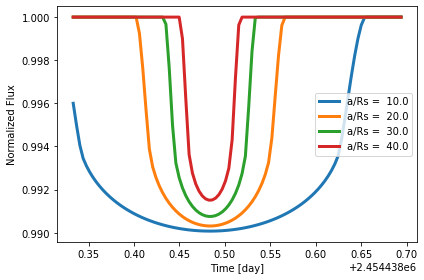

In [24]:
aR_arr = np.arange(10, 50, 10)

for i in np.arange(len(aR_arr)):
    aR = aR_arr[i]
    # Calculate transiting light curve
    flux_array = plc.transit('claret', limb_darkening_coefficients, rp_rs, period, aR, 
                                            eccentricity, inclination, periastron, mid_time, t_array)
    plt.plot(t_array, flux_array, lw=3, label="a/Rs = {0:5.1f}".format(aR))
plt.ylim(plt.ylim()[0], plt.ylim()[1])
plt.xlabel('Time [day]')
plt.ylabel('Normalized Flux')
plt.legend()
plt.tight_layout()

## You may also notice that transit depth decreases as $\frac{a}{R_s}$ increases. This is due to the increasing impact parameter $b$ as $\frac{a}{R_s}$ increases ($b = \frac{a\cos i}{R_s}$). Because of limb darkening, at high $b$ value, planet blocks areas where stellar flux is low, resulting a low transit depth. Without limb darkening, transit depth should not be affected by $\frac{a}{R_s}$, as it shown in the next example.

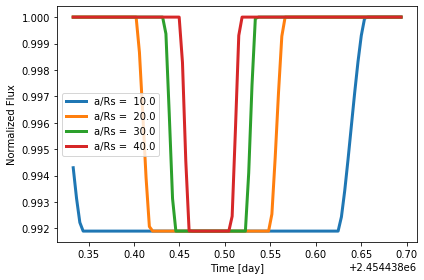

In [25]:
aR_arr = np.arange(10, 50, 10)

for i in np.arange(len(aR_arr)):
    aR = aR_arr[i]
    # Calculate transiting light curve
    flux_array = plc.transit('quad', [0,0], rp_rs, period, aR, 
                                            eccentricity, inclination, periastron, mid_time, t_array)
    plt.plot(t_array, flux_array, lw=3, label="a/Rs = {0:5.1f}".format(aR))
plt.ylim(plt.ylim()[0], plt.ylim()[1])
plt.xlabel('Time [day]')
plt.ylabel('Normalized Flux')
plt.legend()
plt.tight_layout()

## Now let's look at eccentricity $e$ and longtitude of periastron $\omega$. These two parameters are usually considered together to account for planet orbital effect on light curve shape. 

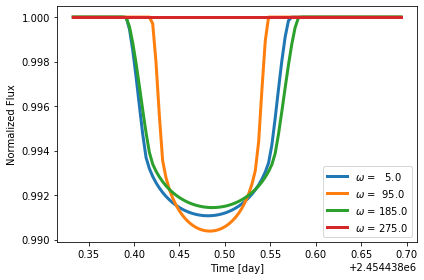

In [26]:
omega_arr = np.array([5, 95, 185, 275])

for i in np.arange(len(omega_arr)):
    omega = omega_arr[i]
    # Calculate transiting light curve
    flux_array = plc.transit('claret', limb_darkening_coefficients, rp_rs, period, sma_over_rs, 
                                            eccentricity, inclination, omega, mid_time, t_array)
    plt.plot(t_array, flux_array, lw=3, ls="-", label="$\omega$ = {0:5.1f}".format(omega))
plt.ylim(plt.ylim()[0], plt.ylim()[1])
plt.xlabel('Time [day]')
plt.ylabel('Normalized Flux')
plt.legend()
plt.tight_layout()

## The above plot shows how transit duration is affected by $\omega$ for a given $e$. At $\omega\sim\ $90 degree, duration is the shortest because transit takes place at periastron when planet travels the fastest. $\omega = 0$ and $\omega = 180$ degree curves look the same and that is why I purposefully offest by 5 degree to make them distinguishable from each other. Note that there is no transit at apoastron ($\omega = 270$ degree) because $b > 1$ due to the high $e$ and large inclination ($i$) of the system. Changing $e$ and $i$ to a reasonable value (e.g., $e=0.3$ and $i=90$ degree as shown below), you can see the transit duration is the longest at apoastron. 

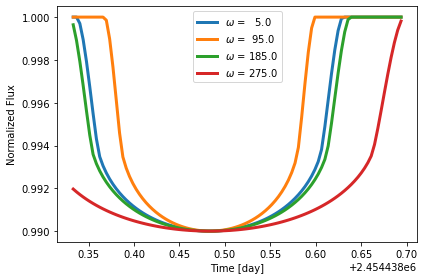

In [27]:
omega_arr = np.array([5, 95, 185, 275])

for i in np.arange(len(omega_arr)):
    omega = omega_arr[i]
    # Calculate transiting light curve
    flux_array = plc.transit('claret', limb_darkening_coefficients, rp_rs, period, sma_over_rs, 
                                            0.3, 90.0, omega, mid_time, t_array)
    plt.plot(t_array, flux_array, lw=3, ls="-", label="$\omega$ = {0:5.1f}".format(omega))
plt.ylim(plt.ylim()[0], plt.ylim()[1])
plt.xlabel('Time [day]')
plt.ylabel('Normalized Flux')
plt.legend()
plt.tight_layout()

## Since transit observations are heavily biased towards systems with low $\frac{a}{R_s}$, for most eccentric systems, we would preferentially observe those systems at periastron, i.e., $\omega\sim90$ degree.

## Now let's fix $\omega$ at 90 degree and vary eccentricity:

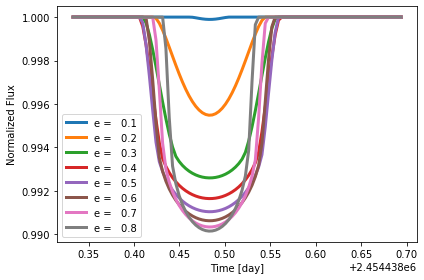

In [28]:
e_arr = np.arange(0.1, 0.9, 0.1)

for i in np.arange(len(e_arr)):
    e = e_arr[i]
    # Calculate transiting light curve
    flux_array = plc.transit('claret', limb_darkening_coefficients, rp_rs, period, sma_over_rs, 
                                            e, inclination, 90, mid_time, t_array)
    plt.plot(t_array, flux_array, lw=3, ls="-", label="e = {0:5.1f}".format(e))
plt.ylim(plt.ylim()[0], plt.ylim()[1])
plt.xlabel('Time [day]')
plt.ylabel('Normalized Flux')
plt.legend()
plt.tight_layout()

## At low eccentricities, the periastron, $a(1-e)$, is too far such that the planet does not transit or grazes the star, producing not transiting signal or a "V" shape shallow transit. However, at high eccentricities, transit duration is shorter and shorter.

## Since transit duration is a function of orbital period $P$ and stellar density $\rho$ (equation 19, correct only for the $e=0$ case). $P$ is usually very precisely measured in a transit observation. If $\rho$ can be independently accurately measured, the inferred transit duration (at $e=0$) can be compared to the actural transit duration. Any inconsistency would imply that the orbital eccentricity is sizable. 

## Now we will look into how inclination include the shape of a lightcurve

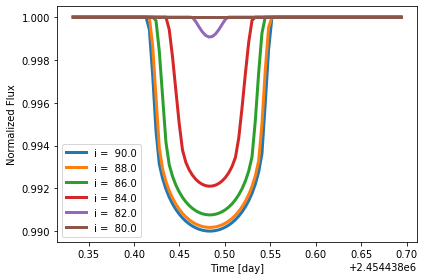

In [29]:
inc_arr = 90.0 - np.arange(0, 11, 2)

for i in np.arange(len(inc_arr)):
    inc = inc_arr[i]
    # Calculate transiting light curve
    flux_array = plc.transit('claret', limb_darkening_coefficients, rp_rs, period, sma_over_rs, 
                                            eccentricity, inc, 90, mid_time, t_array)
    plt.plot(t_array, flux_array, lw=3, ls="-", label="i = {0:5.1f}".format(inc))
plt.ylim(plt.ylim()[0], plt.ylim()[1])
plt.xlabel('Time [day]')
plt.ylabel('Normalized Flux')
plt.legend()
plt.tight_layout()

## As orbital inclination deceases ($i=90$ degree being edge-on), the impact parameter $b$ increases from 0 to a larger value, the transit duration is getting shorter and eventually the planet stops transitng the star because $b>1$.

## Lastly, we will take a look at mid-transit timing, the effect of which is easily understood: the mid-transit timing will shift the transit centroid left or right.

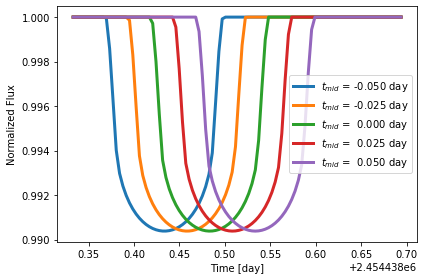

In [30]:
mid_arr = mid_time + np.linspace(-0.05, 0.05, 5)

for i in np.arange(len(mid_arr)):
    mid = mid_arr[i]
    # Calculate transiting light curve
    flux_array = plc.transit('claret', limb_darkening_coefficients, rp_rs, period, sma_over_rs, 
                                            eccentricity, inclination, 90, mid, t_array)
    plt.plot(t_array, flux_array, lw=3, ls="-", label="$t_{mid}$"+" = {0:6.3f} day".format(mid - mid_time))
plt.ylim(plt.ylim()[0], plt.ylim()[1])
plt.xlabel('Time [day]')
plt.ylabel('Normalized Flux')
plt.legend()
plt.tight_layout()

## By now, we have covered how each parameter in a transit lightcurve model affects the shape of a lightcurve. 